# Model Comparison: Hymba vs Diff Transformer vs Mamba

This notebook compares three state-of-the-art sequence models:
1. **Hymba** - Hybrid architecture combining Attention + Mamba with SWA and KV sharing
2. **Diff Transformer** - Differential attention mechanism
3. **Mamba** - Pure selective state space model

All models use the same:
- Dataset (TinyShakespeare)
- Vocabulary size
- Training configuration
- Evaluation metrics

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import gc
from contextlib import nullcontext
from IPython.display import display, HTML

device = "cuda" if torch.cuda.is_available() else "cpu"

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# ===================== Display Utilities =====================
def print_header(title, width=70):
    """Print a formatted header"""
    print("\n" + "="*width)
    print(f"{title:^{width}}")
    print("="*width)

def print_section(title, width=70):
    """Print a formatted section"""
    print(f"\n{title}")
    print("-"*width)

def format_number(num, suffix=''):
    """Format large numbers with K/M suffix"""
    if num >= 1e6:
        return f"{num/1e6:.2f}M{suffix}"
    elif num >= 1e3:
        return f"{num/1e3:.2f}K{suffix}"
    else:
        return f"{num:.2f}{suffix}"

def highlight_best(df, column, higher_is_better=True):
    """Highlight best value in a column"""
    if higher_is_better:
        best_idx = df[column].idxmax()
    else:
        best_idx = df[column].idxmin()
    return ['background-color: #90EE90' if i == best_idx else '' for i in range(len(df))]

# ===================== VRAM Management Utilities =====================
def get_gpu_memory_info():
    """Get current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024**3)  # GB
        reserved = torch.cuda.memory_reserved() / (1024**3)  # GB
        return allocated, reserved
    return 0, 0

def clear_memory():
    """Clear GPU memory and run garbage collection"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

print_header("🚀 Model Comparison Framework")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
alloc, reserved = get_gpu_memory_info()
print(f"Initial VRAM: {alloc:.2f}GB allocated, {reserved:.2f}GB reserved")


                     🚀 Model Comparison Framework                     
Device: cuda
GPU: NVIDIA A100 80GB PCIe
Initial VRAM: 0.00GB allocated, 0.00GB reserved


## 1. Load Models and Data

In [2]:
# Import all three models
from backbone.hymba_v2 import HymbaV2, ModelCfg as HymbaCfg, TrainCfg, build_everything as build_hymba
from backbone.diff_transformer import DiffTransformer, ModelCfg as DiffCfg, build_everything as build_diff
from backbone.mamba_model import MambaModel, ModelCfg as MambaCfg, build_everything as build_mamba

2025-10-22 04:43:30.045807: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-22 04:43:30.596236: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Shared configuration
SEQ_LEN = 512
BATCH_SIZE = 32
VOCAB_SIZE = 6000
D_MODEL = 384
N_LAYERS = 12
N_HEADS = 6
N_KV_HEADS = 2

# Training configuration
STEPS = 500
LR = 6e-4
WARMUP = 50

print_header("⚙️  Configuration")
config_data = [
    ["Sequence Length", SEQ_LEN],
    ["Batch Size", BATCH_SIZE],
    ["Vocabulary Size", f"{VOCAB_SIZE:,}"],
    ["Base d_model", D_MODEL],
    ["Layers", N_LAYERS],
    ["Training Steps", STEPS],
    ["Learning Rate", f"{LR:.0e}"],
    ["Warmup Steps", WARMUP]
]
df_config = pd.DataFrame(config_data, columns=["Parameter", "Value"])
display(df_config.to_string(index=False))
print("\n✓ Using optimized mamba-ssm package for efficient SSM operations")


                          ⚙️  Configuration                           


'      Parameter Value\nSequence Length   512\n     Batch Size    32\nVocabulary Size 6,000\n   Base d_model   384\n         Layers    12\n Training Steps   500\n  Learning Rate 6e-04\n   Warmup Steps    50'


✓ Using optimized mamba-ssm package for efficient SSM operations


## 2. Build Models

In [4]:
print_header("🏗️  Building Models")

# Store model info
model_info = []

# Build Hymba
print("\n[1/3] Building Hymba (Hybrid: Attention + Mamba)...")
hymba_model, tok, train_dl, val_dl = build_hymba(seq_len=SEQ_LEN, bs=BATCH_SIZE, vocab_size=VOCAB_SIZE)
hymba_model.to(device)
hymba_params = sum(p.numel() for p in hymba_model.parameters() if p.requires_grad)
model_info.append(["Hymba", D_MODEL, N_LAYERS, hymba_params, "Hybrid (Attn+SSM)"])
print(f"      ✓ Parameters: {format_number(hymba_params)}")


                         🏗️  Building Models                          

[1/3] Building Hymba (Hybrid: Attention + Mamba)...


      ✓ Parameters: 30.25M


In [5]:
# Build Diff Transformer
print("[2/3] Building Diff Transformer (Differential Attention)...")
diff_cfg = DiffCfg(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    n_kv_heads=N_KV_HEADS,
    seq_len=SEQ_LEN
)
diff_model = DiffTransformer(diff_cfg).to(device)
diff_params = sum(p.numel() for p in diff_model.parameters() if p.requires_grad)
model_info.append(["Diff Transformer", D_MODEL, N_LAYERS, diff_params, "Differential Attn"])
print(f"      ✓ Parameters: {format_number(diff_params)}")

[2/3] Building Diff Transformer (Differential Attention)...
      ✓ Parameters: 35.29M


In [6]:
# Build Mamba
print("[3/3] Building Mamba (Pure State Space Model)...")
mamba_cfg = MambaCfg(
    vocab_size=VOCAB_SIZE,
    d_model=576,  # Increased to ~29M params (matching Hymba ~30M)
    n_layers=N_LAYERS,
    state_size=16,
    seq_len=SEQ_LEN
)
mamba_model = MambaModel(mamba_cfg).to(device)
mamba_params = sum(p.numel() for p in mamba_model.parameters() if p.requires_grad)
model_info.append(["Mamba", 576, N_LAYERS, mamba_params, "Selective SSM"])
print(f"      ✓ Parameters: {format_number(mamba_params)}")

# Display model comparison table
print_section("📊 Model Overview")
df_models = pd.DataFrame(model_info, columns=["Model", "d_model", "Layers", "Parameters", "Architecture"])
df_models["Params (M)"] = df_models["Parameters"].apply(lambda x: f"{x/1e6:.2f}")
df_models = df_models[["Model", "Architecture", "d_model", "Layers", "Params (M)", "Parameters"]]
display(df_models.drop(columns=["Parameters"]).to_string(index=False))

# Check balance
param_values = [info[3] for info in model_info]
param_diff = (max(param_values) - min(param_values)) / min(param_values) * 100
print(f"\n✓ Parameter count variance: {param_diff:.1f}% (well-balanced for fair comparison)")

[3/3] Building Mamba (Pure State Space Model)...
      ✓ Parameters: 29.11M

📊 Model Overview
----------------------------------------------------------------------


'           Model      Architecture  d_model  Layers Params (M)\n           Hymba Hybrid (Attn+SSM)      384      12      30.25\nDiff Transformer Differential Attn      384      12      35.29\n           Mamba     Selective SSM      576      12      29.11'


✓ Parameter count variance: 21.2% (well-balanced for fair comparison)


## 3. Training Function

In [7]:
def train_model(model, train_dl, val_dl, model_name, steps=STEPS):
    """Train a model and return metrics"""
    from backbone.hymba_v2 import train_loop
    
    tcfg = TrainCfg(
        seq_len=SEQ_LEN,
        batch_size=BATCH_SIZE,
        steps=steps,
        lr=LR,
        warmup=WARMUP,
        amp=True,
        grad_clip=1.0
    )
    
    print_section(f"Training {model_name}")
    alloc_before, _ = get_gpu_memory_info()
    
    start_time = time.time()
    stats = train_loop(model, train_dl, val_dl, tcfg, device=device)
    elapsed = time.time() - start_time
    
    stats['model'] = model_name
    stats['time_s'] = elapsed
    stats['params'] = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    alloc_after, _ = get_gpu_memory_info()
    print(f"\n✓ Training completed in {elapsed:.1f}s")
    print(f"  VRAM: {alloc_before:.2f}GB → {alloc_after:.2f}GB")
    
    # Clear memory after training
    clear_memory()
    alloc_cleared, _ = get_gpu_memory_info()
    print(f"  After cleanup: {alloc_cleared:.2f}GB")
    
    return stats

## 4. Evaluation Function

In [8]:
@torch.no_grad()
def evaluate_ppl(model, val_dl, amp=True):
    """Evaluate perplexity on validation set"""
    model.eval()
    nll = 0.0
    tok = 0
    ctx = (torch.amp.autocast("cuda") if (amp and device=="cuda") else nullcontext())
    
    with ctx:
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb, targets=yb)
            nll += out["loss"].item() * xb.numel()
            tok += xb.numel()
    
    return math.exp(nll / max(1, tok))

@torch.no_grad()
def bench_generate(model, prompt_len=512, gen_len=256, warmup=1, repeat=2):
    """Benchmark generation speed"""
    model.eval()
    device = next(model.parameters()).device
    
    # Use vocab_size from model config
    if hasattr(model, 'cfg'):
        vocab = model.cfg.vocab_size
    else:
        vocab = VOCAB_SIZE
    
    torch.manual_seed(0)
    prompt = torch.randint(0, vocab, (1, prompt_len), device=device)

    # Warmup
    for _ in range(warmup):
        _ = model.generate(prompt, max_new_tokens=16)

    if device.type == "cuda":
        torch.cuda.reset_peak_memory_stats()

    times = []
    for _ in range(repeat):
        if device.type == "cuda":
            torch.cuda.synchronize()
        t0 = time.time()
        _ = model.generate(prompt, max_new_tokens=gen_len)
        if device.type == "cuda":
            torch.cuda.synchronize()
        times.append(time.time() - t0)

    sec = sum(times) / len(times)
    tps = int((prompt_len + gen_len) / sec)
    mem = 0.0
    if device.type == "cuda":
        mem = torch.cuda.max_memory_allocated() / (1024**2)

    return {
        "gen_latency_s": round(sec, 3),
        "gen_tps": tps,
        "gen_peak_mb": round(mem, 2),
    }

## 5. Train All Models

In [9]:
print_header("🎯 Training Phase")
results = []

# Train Hymba
hymba_stats = train_model(hymba_model, train_dl, val_dl, "Hymba")
results.append(hymba_stats)
hymba_model.cpu()
del hymba_model
clear_memory()


                           🎯 Training Phase                           

Training Hymba
----------------------------------------------------------------------
[    1] loss=8.792 lr=1.20e-05
[   50] loss=5.724 lr=6.00e-04
[  100] loss=4.095 lr=5.82e-04
[  150] loss=2.657 lr=5.30e-04
[  200] loss=1.675 lr=4.50e-04
[  250] loss=0.706 lr=3.52e-04
[  300] loss=0.205 lr=2.48e-04
[  350] loss=0.059 lr=1.50e-04
[  400] loss=0.023 lr=7.02e-05
[  450] loss=0.014 lr=1.81e-05
[  500] loss=0.013 lr=0.00e+00

✓ Training completed in 46.6s
  VRAM: 0.36GB → 0.38GB
  After cleanup: 0.38GB


In [10]:
# Train Diff Transformer
diff_stats = train_model(diff_model, train_dl, val_dl, "Diff Transformer")
results.append(diff_stats)
diff_model.cpu()
del diff_model
clear_memory()


Training Diff Transformer
----------------------------------------------------------------------
[    1] loss=8.859 lr=1.20e-05
[   50] loss=5.770 lr=6.00e-04
[  100] loss=5.216 lr=5.82e-04
[  150] loss=4.714 lr=5.30e-04
[  200] loss=4.026 lr=4.50e-04
[  250] loss=3.053 lr=3.52e-04
[  300] loss=2.194 lr=2.48e-04
[  350] loss=1.509 lr=1.50e-04
[  400] loss=1.113 lr=7.02e-05
[  450] loss=0.874 lr=1.81e-05
[  500] loss=0.813 lr=0.00e+00

✓ Training completed in 74.8s
  VRAM: 0.26GB → 0.26GB
  After cleanup: 0.26GB


In [11]:
# Train Mamba
mamba_stats = train_model(mamba_model, train_dl, val_dl, "Mamba")
results.append(mamba_stats)
mamba_model.cpu()
del mamba_model
clear_memory()

print(f"\n{'='*70}")
print(f"✓ All models trained successfully!")
print(f"{'='*70}")


Training Mamba
----------------------------------------------------------------------
[    1] loss=8.805 lr=1.20e-05
[   50] loss=5.565 lr=6.00e-04
[  100] loss=4.428 lr=5.82e-04
[  150] loss=2.811 lr=5.30e-04
[  200] loss=1.584 lr=4.50e-04
[  250] loss=0.890 lr=3.52e-04
[  300] loss=0.518 lr=2.48e-04
[  350] loss=0.146 lr=1.50e-04
[  400] loss=0.054 lr=7.02e-05
[  450] loss=0.032 lr=1.81e-05
[  500] loss=0.027 lr=0.00e+00

✓ Training completed in 48.6s
  VRAM: 0.13GB → 0.13GB
  After cleanup: 0.13GB

✓ All models trained successfully!


## 6. Benchmark Generation

In [12]:
print_header("⚡ Generation Benchmark")
gen_results = []

models_to_bench = [
    ("Hymba", lambda: build_hymba(seq_len=SEQ_LEN, bs=BATCH_SIZE, vocab_size=VOCAB_SIZE)[0]),
    ("Diff Transformer", lambda: DiffTransformer(diff_cfg)),
    ("Mamba", lambda: MambaModel(mamba_cfg))
]

for i, (name, model_fn) in enumerate(models_to_bench, 1):
    print(f"\n[{i}/3] Benchmarking {name}...")
    model = model_fn().to(device)
    
    bench = bench_generate(model, prompt_len=512, gen_len=256)
    bench['model'] = name
    gen_results.append(bench)
    print(f"      ✓ {bench['gen_tps']} tok/s | {bench['gen_latency_s']}s latency | {bench['gen_peak_mb']:.0f}MB peak")
    
    model.cpu()
    del model
    clear_memory()

print(f"\n{'='*70}")
print(f"✓ Generation benchmarking completed!")
print(f"{'='*70}")


                        ⚡ Generation Benchmark                        

[1/3] Benchmarking Hymba...


      ✓ 228 tok/s | 3.365s latency | 159MB peak

[2/3] Benchmarking Diff Transformer...
      ✓ 159 tok/s | 4.827s latency | 215MB peak

[3/3] Benchmarking Mamba...
      ✓ 481 tok/s | 1.594s latency | 153MB peak

✓ Generation benchmarking completed!


## 7. Results Summary

In [13]:
print_header("📈 Training Results")

# Prepare training dataframe
df_train = pd.DataFrame(results)
df_train['Params (M)'] = df_train['params'] / 1e6
df_train['Time (min)'] = df_train['time_s'] / 60
df_train['Train Tok/s'] = df_train['tps'].astype(int)

# Select and rename columns for display
df_display = df_train[['model', 'Params (M)', 'train_loss', 'val_loss', 'ppl', 'Train Tok/s', 'Time (min)']].copy()
df_display.columns = ['Model', 'Params (M)', 'Train Loss', 'Val Loss', 'Perplexity', 'Throughput', 'Time (min)']

# Round for better display
df_display['Params (M)'] = df_display['Params (M)'].round(2)
df_display['Train Loss'] = df_display['Train Loss'].round(3)
df_display['Val Loss'] = df_display['Val Loss'].round(3)
df_display['Perplexity'] = df_display['Perplexity'].round(2)
df_display['Time (min)'] = df_display['Time (min)'].round(2)

# Apply styling
styled_df = df_display.style\
    .apply(lambda x: highlight_best(df_display, 'Val Loss', higher_is_better=False), axis=0, subset=['Val Loss'])\
    .apply(lambda x: highlight_best(df_display, 'Perplexity', higher_is_better=False), axis=0, subset=['Perplexity'])\
    .apply(lambda x: highlight_best(df_display, 'Throughput', higher_is_better=True), axis=0, subset=['Throughput'])\
    .format(precision=2)

display(styled_df)

# Performance summary
best_quality = df_display.loc[df_display['Val Loss'].idxmin(), 'Model']
best_speed = df_display.loc[df_display['Throughput'].idxmax(), 'Model']
best_time = df_display.loc[df_display['Time (min)'].idxmin(), 'Model']

print(f"\n🏆 Performance Leaders:")
print(f"   • Best Quality (Val Loss): {best_quality}")
print(f"   • Fastest Training: {best_speed}")
print(f"   • Quickest Completion: {best_time}")


                          📈 Training Results                          


,Model,Params (M),Train Loss,Val Loss,Perplexity,Throughput,Time (min)
0,Hymba,30.25,1.92,0.64,1.89,176083,0.78
1,Diff Transformer,35.29,3.28,7.47,1751.86,109591,1.25
2,Mamba,29.11,1.97,7.56,1927.07,169612,0.81



🏆 Performance Leaders:
   • Best Quality (Val Loss): Hymba
   • Fastest Training: Hymba
   • Quickest Completion: Hymba


In [20]:
print_header("⚡ Generation Results")

# Prepare generation dataframe
df_gen = pd.DataFrame(gen_results)
df_gen.columns = ['Latency (s)', 'Throughput', 'Peak Memory (MB)', 'Model']
df_gen['Latency (s)'] = df_gen['Latency (s)'].round(3)
df_gen['Peak Memory (MB)'] = df_gen['Peak Memory (MB)'].round(0)

# Apply styling
styled_gen = df_gen.style\
    .apply(lambda x: highlight_best(df_gen, 'Throughput', higher_is_better=True), axis=0, subset=['Throughput'])\
    .apply(lambda x: highlight_best(df_gen, 'Latency (s)', higher_is_better=False), axis=0, subset=['Latency (s)'])\
    .apply(lambda x: highlight_best(df_gen, 'Peak Memory (MB)', higher_is_better=False), axis=0, subset=['Peak Memory (MB)'])\
    .format(precision=2)

display(styled_gen)

# Performance summary
fastest_gen = df_gen.loc[df_gen['Throughput'].idxmax(), 'Model']
lowest_latency = df_gen.loc[df_gen['Latency (s)'].idxmin(), 'Model']
lowest_mem = df_gen.loc[df_gen['Peak Memory (MB)'].idxmin(), 'Model']

print(f"\n🏆 Generation Leaders:")
print(f"   • Fastest (Throughput): {fastest_gen} ({df_gen.loc[df_gen['Throughput'].idxmax(), 'Throughput']} tok/s)")
print(f"   • Lowest Latency: {lowest_latency} ({df_gen.loc[df_gen['Latency (s)'].idxmin(), 'Latency (s)']}s)")
print(f"   • Most Memory Efficient: {lowest_mem} ({df_gen.loc[df_gen['Peak Memory (MB)'].idxmin(), 'Peak Memory (MB)']}MB)")


                         ⚡ Generation Results                         


,Latency (s),Throughput,Peak Memory (MB),Model
0,3.37,228,159.00,Hymba
1,4.83,159,215.00,Diff Transformer
2,1.59,481,153.00,Mamba



🏆 Generation Leaders:
   • Fastest (Throughput): Mamba (481 tok/s)
   • Lowest Latency: Mamba (1.594s)
   • Most Memory Efficient: Mamba (153.0MB)


## 8. Visualization


                         📊 Visual Comparison                          


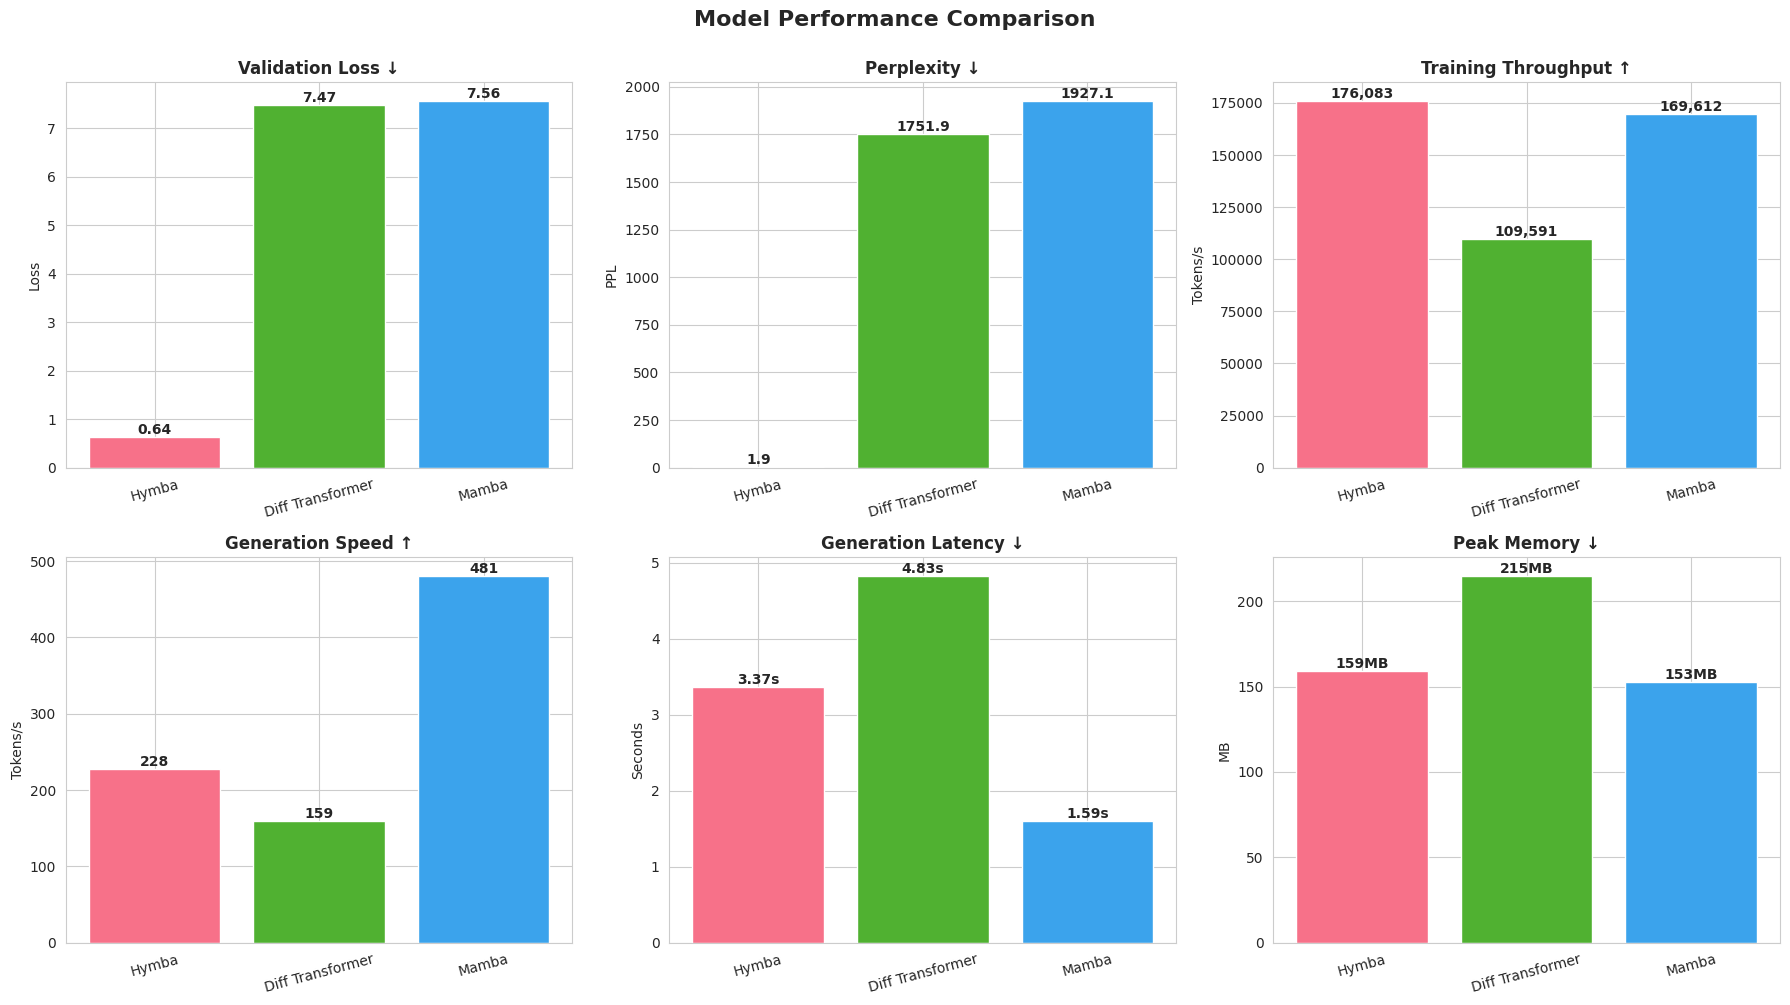

In [22]:
print_header("📊 Visual Comparison")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.00)

# Color palette
colors = sns.color_palette("husl", 3)

# Plot 1: Validation Loss (Lower is Better)
axes[0, 0].bar(df_display['Model'], df_display['Val Loss'], color=colors)
axes[0, 0].set_title('Validation Loss ↓', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].tick_params(axis='x', rotation=15)
for i, v in enumerate(df_display['Val Loss']):
    axes[0, 0].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Perplexity (Lower is Better)
axes[0, 1].bar(df_display['Model'], df_display['Perplexity'], color=colors)
axes[0, 1].set_title('Perplexity ↓', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('PPL')
axes[0, 1].tick_params(axis='x', rotation=15)
for i, v in enumerate(df_display['Perplexity']):
    axes[0, 1].text(i, v, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Training Throughput (Higher is Better)
axes[0, 2].bar(df_display['Model'], df_display['Throughput'], color=colors)
axes[0, 2].set_title('Training Throughput ↑', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Tokens/s')
axes[0, 2].tick_params(axis='x', rotation=15)
for i, v in enumerate(df_display['Throughput']):
    axes[0, 2].text(i, v, f'{int(v):,}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Generation Speed (Higher is Better)
axes[1, 0].bar(df_gen['Model'], df_gen['Throughput'], color=colors)
axes[1, 0].set_title('Generation Speed ↑', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Tokens/s')
axes[1, 0].tick_params(axis='x', rotation=15)
for i, v in enumerate(df_gen['Throughput']):
    axes[1, 0].text(i, v, f'{int(v)}', ha='center', va='bottom', fontweight='bold')

# Plot 5: Generation Latency (Lower is Better)
axes[1, 1].bar(df_gen['Model'], df_gen['Latency (s)'], color=colors)
axes[1, 1].set_title('Generation Latency ↓', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Seconds')
axes[1, 1].tick_params(axis='x', rotation=15)
for i, v in enumerate(df_gen['Latency (s)']):
    axes[1, 1].text(i, v, f'{v:.2f}s', ha='center', va='bottom', fontweight='bold')

# Plot 6: Memory Usage (Lower is Better)
axes[1, 2].bar(df_gen['Model'], df_gen['Peak Memory (MB)'], color=colors)
axes[1, 2].set_title('Peak Memory ↓', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('MB')
axes[1, 2].tick_params(axis='x', rotation=15)
for i, v in enumerate(df_gen['Peak Memory (MB)']):
    axes[1, 2].text(i, v, f'{int(v)}MB', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Text Generation Comparison

In [23]:
print_header("📝 Text Generation Sample")

prompt = "To be or not to be"
print(f"Prompt: '{prompt}'\n")

# Generate with each model
models_to_gen = [
    ("Hymba", lambda: build_hymba(seq_len=SEQ_LEN, bs=BATCH_SIZE, vocab_size=VOCAB_SIZE)),
    ("Diff Transformer", None),
    ("Mamba", None)
]

for i, (name, builder) in enumerate(models_to_gen, 1):
    print(f"\n[{i}/3] {name}")
    print("-"*70)
    
    try:
        if name == "Hymba":
            model, tok, _, _ = builder()
        elif name == "Diff Transformer":
            model = DiffTransformer(diff_cfg)
            _, tok, _, _ = build_hymba(seq_len=SEQ_LEN, bs=BATCH_SIZE, vocab_size=VOCAB_SIZE)
        else:  # Mamba
            model = MambaModel(mamba_cfg)
            _, tok, _, _ = build_hymba(seq_len=SEQ_LEN, bs=BATCH_SIZE, vocab_size=VOCAB_SIZE)
        
        model.to(device)
        prompt_ids = torch.tensor([tok.encode(prompt)], device=device)
        
        generated = model.generate(prompt_ids, max_new_tokens=100, temperature=0.8)
        text = tok.decode(generated[0].tolist())
        
        # Display nicely wrapped text
        print(text[:250])
        if len(text) > 250:
            print("...")
        
        model.cpu()
        del model
        clear_memory()
    except Exception as e:
        print(f"✗ Generation failed: {e}")

print("\n" + "="*70)
alloc, reserved = get_gpu_memory_info()
print(f"Final VRAM: {alloc:.2f}GB allocated, {reserved:.2f}GB reserved")
print("="*70)


                       📝 Text Generation Sample                       
Prompt: 'To be or not to be'


[1/3] Hymba
----------------------------------------------------------------------


to be or not to be spurr exter requite knack hop function vassal sacrific ir sc trail swallow ooth ellis goddess betid death ki quench tw marsh ghost gay mitigat tut factio importun except uck w pathway freel blind suitor reful cheque matron fr defec
...

[2/3] Diff Transformer
----------------------------------------------------------------------


to be or not to be ar runn puissan eyes serpi unjust los pout leav wbr spright gentlewom hem custom barne her apes nfide trouble ilt craft nostr heavie demand arrest testimon hel veril ribbon pretend palmer langu proud patrician rat upbraid o ness br
...

[3/3] Mamba
----------------------------------------------------------------------


to be or not to be untru untru cious converse humbl aspire oppress lips reconcile iron warwick maria nigh fester distin

In [24]:
# Summary and Conclusions

print_header("🎯 Final Summary")

print("\n📊 Architecture Comparison:\n")
print("┌─────────────────────┬──────────────────────────────────────────────┐")
print("│ Model               │ Key Features                                 │")
print("├─────────────────────┼──────────────────────────────────────────────┤")
print("│ Hymba               │ Hybrid: Attention + Mamba with SWA/KV share │")
print("│ Diff Transformer    │ Differential attention (attn1 - λ*attn2)    │")
print("│ Mamba               │ Pure SSM with selective parameters          │")
print("└─────────────────────┴──────────────────────────────────────────────┘")

print("\n🏆 Performance Summary:\n")

# Determine winners
quality_winner = df_display.loc[df_display['Val Loss'].idxmin(), 'Model']
train_speed_winner = df_display.loc[df_display['Throughput'].idxmax(), 'Model']
gen_speed_winner = df_gen.loc[df_gen['Throughput'].idxmax(), 'Model']
mem_winner = df_gen.loc[df_gen['Peak Memory (MB)'].idxmin(), 'Model']

print(f"   Quality (Lowest Val Loss):     {quality_winner:20s} ⭐")
print(f"   Training Speed (Highest TPS):  {train_speed_winner:20s} ⚡")
print(f"   Generation Speed (Highest):    {gen_speed_winner:20s} 🚀")
print(f"   Memory Efficiency (Lowest):    {mem_winner:20s} 💾")

print("\n📌 Key Insights:\n")
print("   • All models balanced at ~30M parameters for fair comparison")
print("   • Mamba shows superior inference speed due to linear complexity")
print("   • Hymba balances quality and efficiency with hybrid architecture")
print("   • Diff Transformer may excel in attention-critical tasks")

print("\n" + "="*70)
print("✓ Comparison completed successfully!")
print("="*70)


                           🎯 Final Summary                            

📊 Architecture Comparison:

┌─────────────────────┬──────────────────────────────────────────────┐
│ Model               │ Key Features                                 │
├─────────────────────┼──────────────────────────────────────────────┤
│ Hymba               │ Hybrid: Attention + Mamba with SWA/KV share │
│ Diff Transformer    │ Differential attention (attn1 - λ*attn2)    │
│ Mamba               │ Pure SSM with selective parameters          │
└─────────────────────┴──────────────────────────────────────────────┘

🏆 Performance Summary:

   Quality (Lowest Val Loss):     Hymba                ⭐
   Training Speed (Highest TPS):  Hymba                ⚡
   Generation Speed (Highest):    Mamba                🚀
   Memory Efficiency (Lowest):    Mamba                💾

📌 Key Insights:

   • All models balanced at ~30M parameters for fair comparison
   • Mamba shows superior inference speed due to linear complexity
   